In [2]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [3]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData
from ExtFunctions import interpCores


from Interpolation_Class import Interpolation

In [4]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


In [5]:
site = 'SiteG'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site)

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [18]:
maxDiff = max(np.diff(depth_LT))
minDiff = min(np.diff(depth_LT))
Delta0 = (maxDiff + minDiff)/2

In [10]:
interval = np.array([min(depth_LT), max(depth_LT)])

interpTypeAll = 'CubicSpline'

inst = Interpolation(depth_LT, pd.Series(d18O_LT), interval, interpTypeAll, DeltaInput=True, samplingSize=Delta0)
depth_LT_int, d18O_LT_int, Delta = inst()

20


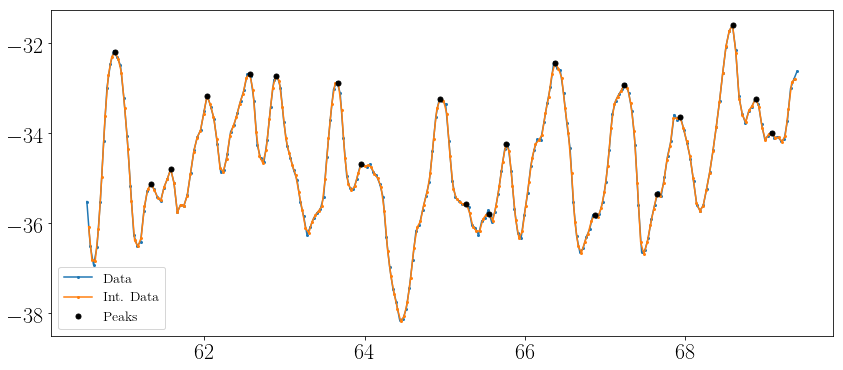

In [12]:
fig, ax = plt.subplots(figsize=(14,6))

from scipy import signal
peaksTest = signal.find_peaks(d18O_LT_int,distance=4)[0]

plt.plot(depth_LT,d18O_LT,'-',marker='.',ms=4, label='Data')
plt.plot(depth_LT_int,d18O_LT_int,'-',marker='.',ms=4, label='Int. Data')
plt.plot(depth_LT_int[peaksTest],d18O_LT_int[peaksTest],'.', color='k', ms=10,label='Peaks')
plt.legend(fontsize=14)
print(len(peaksTest))

In [13]:
dataAll = pd.DataFrame({'depth':depth_LT_int,'d18O':d18O_LT_int}, index=None)

In [14]:
inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, 32, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=False, newDelta=0.005)


Starting sigma: 6.66 [cm]
100. Npeaks: 31, diffLen: 7.669 cm
Final sigma: 8.55 [cm]
Final # of peaks: 32


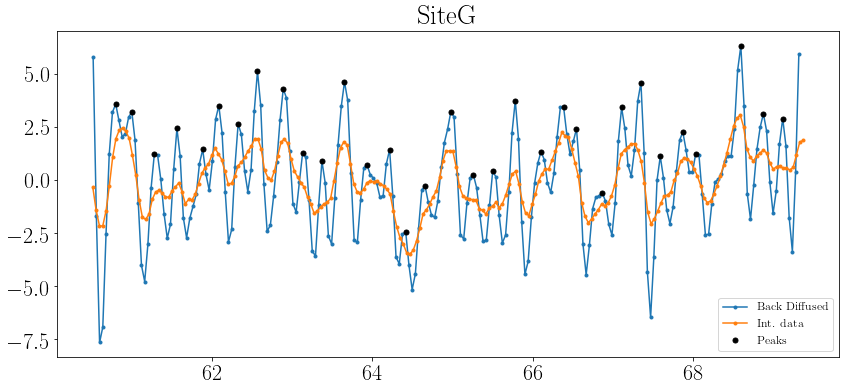

In [13]:
fig, ax = plt.subplots(figsize=(14,6))

plt.plot(depth1,data, '-', marker='.',label='Back Diffused')
plt.plot(depth_LT_int,d18O_LT_int-np.mean(d18O_LT_int),'-',marker='.', label='Int. data')
plt.plot(depth1[peaks],data[peaks],'.', color='k', ms=10, label='Peaks')
plt.title(site)
plt.legend(fontsize=12)

In [44]:
delta_arr = np.linspace(Delta0-Delta0*1/4,Delta0+Delta0*1/4,30)
interval = np.array([min(depth_LT), max(depth_LT)])
interpTypeAll = 'CubicSpline'

diffLens = np.zeros(len(delta_arr))
Npeaks = np.zeros(len(delta_arr))
depths = []
datas = []

for i in range(len(delta_arr)):  
    print(f'\nRun {i}')
    print(f'Delta: {delta_arr[i]:.3f}\n')
    inst = Interpolation(depth_LT, pd.Series(d18O_LT), interval, interpTypeAll, DeltaInput=True, samplingSize=delta_arr[i])
    depth_LT_int, d18O_LT_int, Delta = inst()

    dataAll = pd.DataFrame({'depth':depth_LT_int,'d18O':d18O_LT_int}, index=None)

    inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, 32, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
    diffLen = inst.spectralEstimate()
    difflenEstHL = inst.diffLenEstimateHL()
    depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=False, newDelta=0.005)
    
    Npeaks[i] = len(peaks)
    diffLens[i] = diffLen
    depths.append(depth1)
    datas.append(data)


Run 0
Delta: 0.031

Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.667 cm
Final sigma: 8.03 [cm]
Final # of peaks: 32

Run 1
Delta: 0.031

Starting sigma: 6.66 [cm]
Final sigma: 7.15 [cm]
Final # of peaks: 32

Run 2
Delta: 0.032

Starting sigma: 6.66 [cm]
Final sigma: 7.30 [cm]
Final # of peaks: 32

Run 3
Delta: 0.033

Starting sigma: 6.54 [cm]
Final sigma: 7.48 [cm]
Final # of peaks: 32

Run 4
Delta: 0.034

Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.667 cm
Final sigma: 8.08 [cm]
Final # of peaks: 32

Run 5
Delta: 0.034

Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.667 cm
Final sigma: 8.16 [cm]
Final # of peaks: 32

Run 6
Delta: 0.035

Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.666 cm
Final sigma: 7.99 [cm]
Final # of peaks: 32

Run 7
Delta: 0.036

Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.667 cm
Final sigma: 8.06 [cm]
Final # of peaks: 32

Run 8
Delta: 0.036

Starting sigma: 6.56 [cm]
Final sigma: 7.12 [cm]
Final # of peaks: 32

Run 9

In [45]:
#fig, ax = plt.subplots(figsize=(14,6))
#ax.set(ylim=(-10,10))
#for i in range(len(delta_arr)-2):  
#    ax.plot(depths[i],datas[i], lw=1, marker='.')

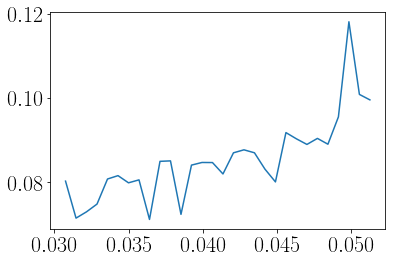

In [47]:
plt.plot(delta_arr, diffLens)